# Subwavelength Grating Adiabatic Splitter Tutorial

This tutorial notebook demonstrates how to perform a `Tidy3D` simulation on a subwavelength grating adiabatic splitter. The geometry is directly imported from a GDS file with the help of the `gdstk` library. A [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeSource.html?highlight=modesource) launches the fundamental TE mode. To characterize the S-parameters, we add four [ModeMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FluxMonitor.html?highlight=modemonitor), which will return the complex S-parameters after the simulation is complete. In addition, a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=fieldmonitor) is added to visualize the field distribution. An automatic non-uniform mesh is used such that the grid size is smaller on the waveguide area, where the fields are concentrated. For the boundaries of the simulation domain, perfectly matched layers (PML) are used to absorb the outgoing energy with minimal reflection, mimicking an infinite space.

Note: running this entire notebook will require over 20 FlexUnits.

## Library Import

We will import a couple of libraries to help us build the simulation, submit the simulation job to the server, and postprocess the simulation results. Besides the main `tidy3d` library, `numpy` and `matplotlib` are used for numerical manipulation and result plotting. In addition, `gdstk` will be used to import the gds file and convert the structures in the gds file to `Tidy3D` geometries. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import gdstk

import tidy3d as td
import tidy3d.web as web
from tidy3d.plugins.mode import ModeSolver

## Define Simulation Frequency (Wavelength) 

The simulation is centered around 1550 nm with a wavelength range of 100 nm. 

In [2]:
lda0 = 1.55  # central wavelength
ldas = np.linspace(1.5, 1.6, 101)  # wavelength range of interest

freq0 = td.C_0 / lda0  # corresponding central frequency
freqs = td.C_0 / ldas  # corresponding frequency range

fwidth = 0.5 * (np.max(freqs) - np.min(freqs))  # width of the excitation frequency spectrum

## Define Materials 

We will define two materials -- silicon and silica. In the wavelength range of interest, both materials have an approximately constant refractive index and nearly zero extinction coefficient. Therefore, we model them as non-dispersive and lossless media. If the simulation wavelength range is large such that dispersion and loss are of importance, we can incorporate them in other ways as introduced in the [dispersive materials tutorial](https://docs.flexcompute.com/projects/tidy3d/en/latest/notebooks/Dispersion.html). 

In [3]:
n_si = 3.48  # silicon refractive index
si = td.Medium(permittivity=n_si**2)

n_sio2 = 1.44  # silicon oxide refractive index
sio2 = td.Medium(permittivity=n_sio2**2)

## Import the Splitter Structure from a gds File 

Next, we use `gdstk` to import the gds file. First, we need to specify the directory and file name of the gds file. In this case, the file is [ebeam_splitter_adiabatic_swg_te1550.gds](https://github.com/SiEPIC/SiEPIC_EBeam_PDK/blob/master/klayout_dot_config/tech/EBeam/gds/development/ebeam_splitter_adiabatic_swg_te1550.gds), which is stored under the same directory as this notebook file.

In [4]:
gds_path = r"C:\Users\ongun\Desktop\EdX_Photonics\ebeam_splitter_adiabatic_swg_te1550.gds"  # path of the gds file

lib = gdstk.read_gds(infile=gds_path)  # import gds file
cell = lib.top_level()[0]  # read cell

Now we will convert the cell into a `Tidy3D` [PolySlab](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.PolySlab.html?highlight=polyslab) using the `from_gds` method. 

The `slab_bounds` is set to `(-h/2,h/2)` such that the splitter has a thickness of *h=220 nm*.

In [5]:
h = 0.22  #thickness of the silicon layer

#convert the gds cell into a tidy3d PolySlab
swg_gds = td.PolySlab.from_gds(
    cell,
    gds_layer=1,
    axis=2,
    slab_bounds=(-h/2, h/2),
)

To confirm the import is correct, we can use the `plot` method to visualize it. The `from_gds()` method returns a list of geometries corresponding to each components in the gds import. To plot the full structure, we use a for loop to interate over the list.

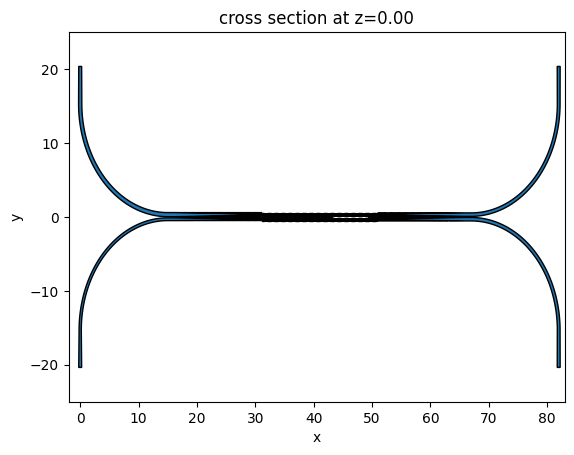

In [6]:
fig, ax = plt.subplots(1,1)
for s in swg_gds:
    s.plot(z=0, ax=ax)
ax.set_xlim(-2,83)
ax.set_ylim(-25,25)
ax.set_aspect('auto')

## Define Structures 

Next, we will make `Tidy3D` [Structures](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Structure.html?highlight=structure). Essentially, a [Structure](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Structure.html?highlight=structure) is a combination of geometry and medium. For the splitter, the geometries are the previously defined [PolySlabs](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.PolySlab.html?highlight=polyslab) and the medium is set to `si`. Again, we use a for loop to interate over the list to make sure every component is included.

In [7]:
swg = []
for s in swg_gds:
    swg.append(td.Structure(geometry=s,
            medium=si))

Another [Structure](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Structure.html?highlight=structure) in the simulation is the substrate, which is a [Box](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Box.html?highlight=box) geometry and `sio2` medium. We define the box using the `from_bounds()` method here for convenience. 

In FDTD simulations, it is very important to make sure the structures  extend into the simulation boundaries instead of stopping right at the boundaries, which is likely to cause numerical issues. Therefore, the substrate is defined to be much larger than the splitter. Later, we will define the simulation domain such that the straight waveguides and the substrate all extend into the boundaries.

In [8]:
substrate = td.Structure(geometry=td.Box.from_bounds(rmin=(-10,-10,-10), rmax=(10,10,-h/2)), medium=sio2)

## Define Sources and Monitors 

For excitation, we define a [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeSource.html?highlight=modesource) to inject the fundamental TE mode from the bottom left (port 1) straight waveguide into the splitter. Four [ModeMonitors](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FluxMonitor.html?highlight=modemonitor) are added. One in the straight waveguide on the bottom right (port 4), one on the top right (port 3), one on the top left (port 2), and one on the bottom left (port 1). These four monitors will measure the complex S-parameters. Lastly, a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=fieldmonitor) is added in the *xy* plane so that we can visualize the field distribution after the simulation to see how the mode propagates.

In [9]:
mode_spec = td.ModeSpec(num_modes=1, target_neff=n_si)

#define a mode source
mode_source = td.ModeSource(
    center=(0, -17.95, 0),
    size=(2, 0, 8 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="+",
    mode_spec=mode_spec,
    mode_index=0,
)

#define a mode monitor on the bottom right waveguide (port 4)
port4 = td.ModeMonitor(
    center=(82, -18, 0),
    size=(2, 0, 8 * h),
    freqs=freqs,
    name="port4",
    mode_spec = mode_spec
)

#define a mode monitor on the top right waveguide (port 3)
port3 = td.ModeMonitor(
    center=(82, 18, 0),
    size=(2, 0, 8 * h),
    freqs=freqs,
    name="port3",
    mode_spec = mode_spec
)

#define a mode monitor on the top left waveguide (port 2)
port2 = td.ModeMonitor(
    center=(0, 18, 0),  
    size=(2, 0, 8 * h),
    freqs=freqs,
    name="port2",
    mode_spec = mode_spec,
)

#define a mode monitor on the bottom left waveguide (port 1)
port1 = td.ModeMonitor(
    center=(0, -18, 0),  
    size=(2, 0, 8 * h),
    freqs=freqs,
    name="port1",
    mode_spec = mode_spec,
)

#define a field monitor in the xy plane
field_monitor = td.FieldMonitor(
    center=(0, 0, 0), size=(td.inf, td.inf, 0), freqs=[freq0], name="field"
)

## Define Simulation 

Now we are ready to define a `Tidy3D` [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.Simulation.html). The run time is set to 3 ps, which should allow the injected energy to sufficiently decay. An automatic nonuniform grid is used with the minimum steps per wavelength set to 15, which should resolve the fields pretty well in this model. PML is added to all boundaries to absorb the outgoing radiation. The simulation domain size is set to 90 *&mu;m* by 38 *&mu;m* in the *x* and *y* directions. This ensures that the straight waveguides extend into the outer PML. The background medium is set to silica, which represents the top cladding. If no cladding or other material is used for cladding, the background medium needs to be changed accordingly.

In [10]:
run_time = 3e-12

sim = td.Simulation(
    size=(90, 38, 10 * h),
    center=(40,0,0),
    grid_spec=td.GridSpec.auto(min_steps_per_wvl=15, wavelength=lda0),
    structures=swg,
    sources=[mode_source],
    monitors=[port1, port2, port3, port4, field_monitor],
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML()),
    medium=sio2,
)

Finally, we can use the `plot` method to visualize the simulation setup. 

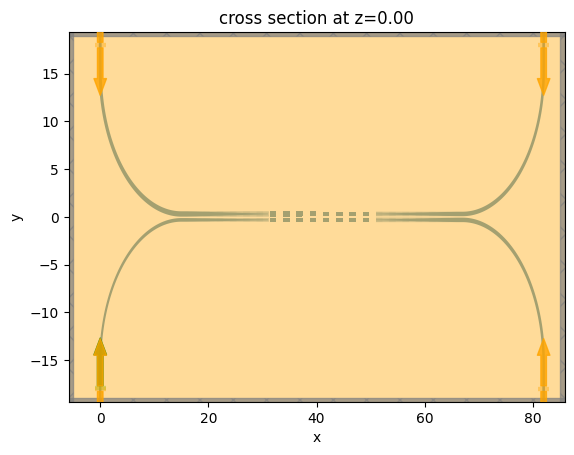

In [11]:
fig, ax = plt.subplots(1,1)

sim.plot(z=0, ax=ax)
ax.set_aspect('auto')

## Visualize the Mode Field 

An optional but recommended step in such a simulation is to visualize the mode field launched by the [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeSource.html?highlight=modesource). This will help us determine if we are launching the correct mode that we try to use. It also helps verify if the size of the [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeSource.html?highlight=modesource) is sufficiently large such that the field decays to zero at the boundaries of the source.

`Tidy3D` provides a [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ModeSolver.html?highlight=modesolver) plugin that you can use to inspect the modes. Here we demonstrate how to use it.

In [12]:
#define the mode solver
mode_solver = ModeSolver(
    simulation=sim,
    plane=td.Box(
    center=(0, -18, 0),  #same as the mode source
    size=(2, 0, 8 * h),  #same as the mode source
    ),
    mode_spec=td.ModeSpec(num_modes=1, target_neff=n_si),
    freqs=[freq0],
)

#solve for the mode
mode_data = mode_solver.solve()

After running the [ModeSolver](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.plugins.ModeSolver.html?highlight=modesolver), we can plot the mode fields. From the plots, we can confirm that the mode is the fundamental TE mode with the dominant polarization in the *x* direction.

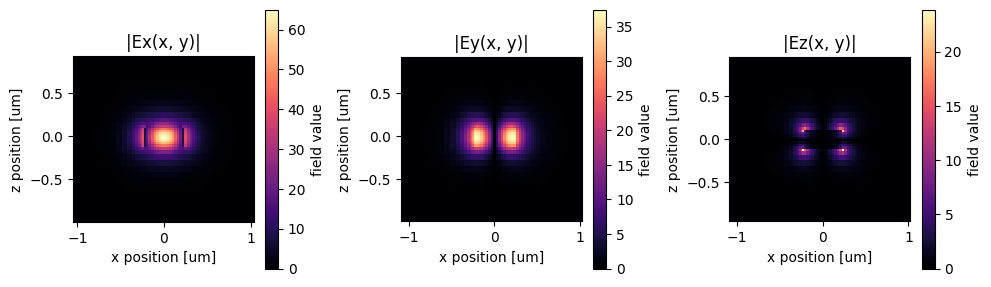

In [15]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, tight_layout=True, figsize=(10, 3))
abs(mode_data.Ex.isel(mode_index=0)).plot(x="x", y="z", ax=ax1, cmap="magma")
abs(mode_data.Ey.isel(mode_index=0)).plot(x="x", y="z", ax=ax2, cmap="magma")
abs(mode_data.Ez.isel(mode_index=0)).plot(x="x", y="z", ax=ax3, cmap="magma")

ax1.set_title("|Ex(x, y)|")
ax1.set_aspect("equal")
ax2.set_title("|Ey(x, y)|")
ax2.set_aspect("equal")
ax3.set_title("|Ez(x, y)|")
ax3.set_aspect("equal")
plt.show()


## Submit the Simulation Job to the Server

Now we are ready to submit the simulation job to the server for computation. After the simulation finishes, the monitor data will be automatically returned.

In [16]:
job = web.Job(simulation=sim, task_name="splitter_adiabatic_swg")
sim_data = job.run(path="data/simulation_data_adiabatic_swg.hdf5")

[23:36:25] Created task 'splitter_adiabatic_swg' with task_id                                         ]8;id=385669;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=759791;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#139\139]8;;\
           'fdve-9bd01bb5-83a1-4cca-a0a2-102f7d256bb5v1'.                                                          

           View task using web UI at                                                                  ]8;id=422882;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=481460;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#141\141]8;;\
           ]8;id=466335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bd01bb5-83a1-4cca-a0a2-102f7d256bb5v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=622184;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bd01bb5-83a1-4cca-a0a2-102f7d256bb5v1\taskId]8;;\]8;id=466335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bd01bb5-83a1-4cca-a0a2-102f7d256bb5v1\=]8;;\]8;id=398635;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bd01bb5-83a1-4cca-a0a2-102f7d256bb5v1\fdve]8;;\]8;id=466335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bd01bb5-83a1-4cca-a0a2-102f7d256bb5v1\-9bd01bb5-83a1-4cca-a0a2-102f7d256bb]8;;\              
           ]8;id=466335;https://tidy3d.simulation.cloud/workbench?taskId=fdve-9bd01bb5-83a1-4cca-a0a2-102f7d256bb5v1\5v1']8;;\.                                                                                                   

Output()

[23:36:36] status = queued                                                                            ]8;id=60217;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=789661;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#271\271]8;;\

Output()

[23:36:43] status = preprocess                                                                        ]8;id=166394;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=522787;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#265\265]8;;\

[23:36:56] Maximum FlexCredit cost: 5.646. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=439114;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=178129;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#288\288]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=859065;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=466039;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#292\292]8;;\

           running solver                                                                             ]8;id=333443;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=545256;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#302\302]8;;\

Output()

[23:39:50] early shutoff detected, exiting.                                                           ]8;id=244717;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=129421;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#316\316]8;;\

           status = postprocess                                                                       ]8;id=610154;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=951708;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#333\333]8;;\

Output()

[23:40:09] status = success                                                                           ]8;id=360939;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=804965;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#340\340]8;;\

Output()

[23:41:21] loading SimulationData from data/simulation_data_adiabatic_swg.hdf5                        ]8;id=434757;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=58508;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#512\512]8;;\

## Result Postprocessing and Visualization 

Now the simulation is complete, we can postprocess and visualize the results. First, we plot the field intensity distribution in the *xy* plane using the data from the [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.FieldMonitor.html?highlight=fieldmonitor). This can be conveniently done by using the `plot_field` method. From the plot, we can see the energy flow from the port 1 to port 3 and port 4.

[23:41:22] WARNING: 'int' field name is deprecated and will be removed in the future. Plese use           ]8;id=425267;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\log.py\log.py]8;;\:]8;id=982515;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\log.py#50\50]8;;\
           field_name='E' and val='abs^2' for the same effect.                                                     

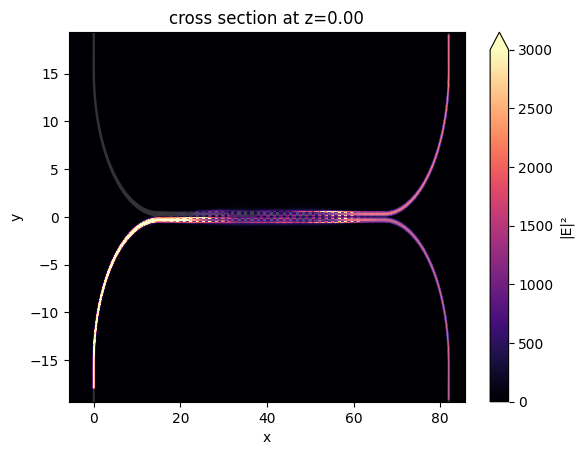

In [17]:
fig, ax = plt.subplots(1,1)

sim_data.plot_field("field", "int", ax=ax, f=freq0, vmin=0, vmax=3000)
ax.set_aspect('auto')


Finally, we obtain the S-parameters and plot them in dB scale. 

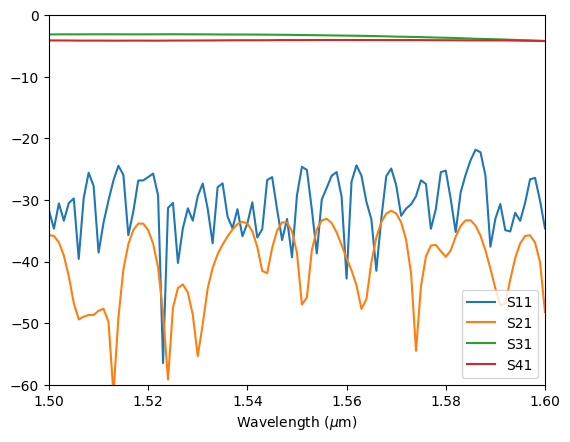

In [18]:
S11 = sim_data["port1"].amps.sel(direction='-').squeeze()
S21 = sim_data["port2"].amps.sel(direction='+').squeeze()
S31 = sim_data["port3"].amps.sel(direction='+').squeeze()
S41 = sim_data["port4"].amps.sel(direction='-').squeeze()

plt.plot(ldas, 20*np.log10(np.abs(S11)), label='S11')
plt.plot(ldas, 20*np.log10(np.abs(S21)), label='S21')
plt.plot(ldas, 20*np.log10(np.abs(S31)), label='S31')
plt.plot(ldas, 20*np.log10(np.abs(S41)), label='S41')

plt.xlim(1.5, 1.6)
plt.ylim(-60, 0)
plt.xlabel("Wavelength ($\mu$m)")
plt.legend()

## Change Excitation Port Position

Other S-parameters can be obtained similarly by moving the [ModeSource](https://docs.flexcompute.com/projects/tidy3d/en/latest/_autosummary/tidy3d.ModeSource.html?highlight=modesource) to other port positions.

In [19]:
mode_source = td.ModeSource(
    center=(0, 17.95, 0),
    size=(2, 0, 8 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="-",
    mode_spec=mode_spec,
    mode_index=0,
)

sim = sim.copy(update={'sources':[mode_source]})
job = web.Job(simulation=sim, task_name="splitter_adiabatic_swg")
sim_data = job.run(path="data/simulation_data_adiabatic_swg2.hdf5")

S12 = sim_data["port1"].amps.sel(direction='-').squeeze()
S22 = sim_data["port2"].amps.sel(direction='+').squeeze()
S32 = sim_data["port3"].amps.sel(direction='+').squeeze()
S42 = sim_data["port4"].amps.sel(direction='-').squeeze()

[23:41:32] Created task 'splitter_adiabatic_swg' with task_id                                         ]8;id=125276;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=604842;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#139\139]8;;\
           'fdve-b64c3deb-b484-48ae-8ddf-7042d3122d2fv1'.                                                          

           View task using web UI at                                                                  ]8;id=467848;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=762367;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#141\141]8;;\
           ]8;id=805114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b64c3deb-b484-48ae-8ddf-7042d3122d2fv1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=349478;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b64c3deb-b484-48ae-8ddf-7042d3122d2fv1\taskId]8;;\]8;id=805114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b64c3deb-b484-48ae-8ddf-7042d3122d2fv1\=]8;;\]8;id=206293;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b64c3deb-b484-48ae-8ddf-7042d3122d2fv1\fdve]8;;\]8;id=805114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b64c3deb-b484-48ae-8ddf-7042d3122d2fv1\-b64c3deb-b484-48ae-8ddf-7042d3122d2]8;;\              
           ]8;id=805114;https://tidy3d.simulation.cloud/workbench?taskId=fdve-b64c3deb-b484-48ae-8ddf-7042d3122d2fv1\fv1']8;;\.                                                                                                   

Output()

[23:41:40] status = queued                                                                            ]8;id=146878;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=901371;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#271\271]8;;\

Output()

[23:41:43] status = preprocess                                                                        ]8;id=800970;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=782555;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#265\265]8;;\

[23:41:53] Maximum FlexCredit cost: 5.646. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=465700;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=646420;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#288\288]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=927426;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=270396;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#292\292]8;;\

           running solver                                                                             ]8;id=540271;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=630232;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#302\302]8;;\

Output()

[23:44:47] early shutoff detected, exiting.                                                           ]8;id=941874;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=791843;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#316\316]8;;\

           status = postprocess                                                                       ]8;id=364237;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=867462;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#333\333]8;;\

Output()

[23:45:06] status = success                                                                           ]8;id=395175;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=251566;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#340\340]8;;\

Output()

[23:46:03] loading SimulationData from data/simulation_data_adiabatic_swg2.hdf5                       ]8;id=294769;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=625104;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#512\512]8;;\

In [20]:
mode_source = td.ModeSource(
    center=(82, 17.95, 0),
    size=(2, 0, 8 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="-",
    mode_spec=mode_spec,
    mode_index=0,
)

sim = sim.copy(update={'sources':[mode_source]})
job = web.Job(simulation=sim, task_name="splitter_adiabatic_swg")
sim_data = job.run(path="data/simulation_data_adiabatic_swg3.hdf5")

S13 = sim_data["port1"].amps.sel(direction='-').squeeze()
S23 = sim_data["port2"].amps.sel(direction='+').squeeze()
S33 = sim_data["port3"].amps.sel(direction='+').squeeze()
S43 = sim_data["port4"].amps.sel(direction='-').squeeze()

[23:46:04] Created task 'splitter_adiabatic_swg' with task_id                                         ]8;id=721895;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=565984;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#139\139]8;;\
           'fdve-2efcde65-4720-46df-ad5d-cfa3eb18f8eev1'.                                                          

           View task using web UI at                                                                  ]8;id=388528;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=403423;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#141\141]8;;\
           ]8;id=481465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2efcde65-4720-46df-ad5d-cfa3eb18f8eev1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=952615;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2efcde65-4720-46df-ad5d-cfa3eb18f8eev1\taskId]8;;\]8;id=481465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2efcde65-4720-46df-ad5d-cfa3eb18f8eev1\=]8;;\]8;id=40866;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2efcde65-4720-46df-ad5d-cfa3eb18f8eev1\fdve]8;;\]8;id=481465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2efcde65-4720-46df-ad5d-cfa3eb18f8eev1\-2efcde65-4720-46df-ad5d-cfa3eb18f8e]8;;\              
           ]8;id=481465;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2efcde65-4720-46df-ad5d-cfa3eb18f8eev1\ev1']8;;\.                                                                                                   

Output()

[23:46:12] status = queued                                                                            ]8;id=804514;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=366950;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#271\271]8;;\

Output()

[23:46:15] status = preprocess                                                                        ]8;id=786317;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=910027;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#265\265]8;;\

[23:46:26] Maximum FlexCredit cost: 5.646. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=209077;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=845262;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#288\288]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=880231;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=897817;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#292\292]8;;\

           running solver                                                                             ]8;id=532504;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=150065;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#302\302]8;;\

Output()

[23:49:17] early shutoff detected, exiting.                                                           ]8;id=224795;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=150725;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#316\316]8;;\

           status = postprocess                                                                       ]8;id=841046;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=924620;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#333\333]8;;\

Output()

[23:49:36] status = success                                                                           ]8;id=543648;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=426804;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#340\340]8;;\

Output()

[23:50:43] loading SimulationData from data/simulation_data_adiabatic_swg3.hdf5                       ]8;id=898403;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=972524;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#512\512]8;;\

In [21]:
mode_source = td.ModeSource(
    center=(82, -17.95, 0),
    size=(2, 0, 8 * h),
    source_time=td.GaussianPulse(freq0=freq0, fwidth=fwidth),
    direction="-",
    mode_spec=mode_spec,
    mode_index=0,
)

sim = sim.copy(update={'sources':[mode_source]})
job = web.Job(simulation=sim, task_name="splitter_adiabatic_swg")
sim_data = job.run(path="data/simulation_data_adiabatic_swg4.hdf5")

S14 = sim_data["port1"].amps.sel(direction='-').squeeze()
S24 = sim_data["port2"].amps.sel(direction='+').squeeze()
S34 = sim_data["port3"].amps.sel(direction='+').squeeze()
S44 = sim_data["port4"].amps.sel(direction='-').squeeze()

[23:50:45] Created task 'splitter_adiabatic_swg' with task_id                                         ]8;id=992590;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=426185;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#139\139]8;;\
           'fdve-2d818016-ad4a-4c5f-baf9-f14d3c74ab20v1'.                                                          

           View task using web UI at                                                                  ]8;id=228338;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=112783;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#141\141]8;;\
           ]8;id=817149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d818016-ad4a-4c5f-baf9-f14d3c74ab20v1\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=176909;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d818016-ad4a-4c5f-baf9-f14d3c74ab20v1\taskId]8;;\]8;id=817149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d818016-ad4a-4c5f-baf9-f14d3c74ab20v1\=]8;;\]8;id=872920;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d818016-ad4a-4c5f-baf9-f14d3c74ab20v1\fdve]8;;\]8;id=817149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d818016-ad4a-4c5f-baf9-f14d3c74ab20v1\-2d818016-ad4a-4c5f-baf9-f14d3c74ab2]8;;\              
           ]8;id=817149;https://tidy3d.simulation.cloud/workbench?taskId=fdve-2d818016-ad4a-4c5f-baf9-f14d3c74ab20v1\0v1']8;;\.                                                                                                   

Output()

[23:50:53] status = queued                                                                            ]8;id=441898;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=219485;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#271\271]8;;\

Output()

[23:50:56] status = preprocess                                                                        ]8;id=518709;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=100828;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#265\265]8;;\

[23:51:07] Maximum FlexCredit cost: 5.646. Use 'web.real_cost(task_id)' to get the billed FlexCredit  ]8;id=916552;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=345534;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#288\288]8;;\
           cost after a simulation run.                                                                            

           starting up solver                                                                         ]8;id=921364;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=100406;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#292\292]8;;\

           running solver                                                                             ]8;id=992419;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=21688;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#302\302]8;;\

Output()

[23:52:58] early shutoff detected, exiting.                                                           ]8;id=521594;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=463377;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#316\316]8;;\

           status = postprocess                                                                       ]8;id=284476;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=509931;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#333\333]8;;\

Output()

[23:53:17] status = success                                                                           ]8;id=619043;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=767154;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#340\340]8;;\

Output()

[23:54:23] loading SimulationData from data/simulation_data_adiabatic_swg4.hdf5                       ]8;id=766835;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py\webapi.py]8;;\:]8;id=659733;file://C:\Users\ongun\.conda\envs\tidy3d_env\lib\site-packages\tidy3d\web\webapi.py#512\512]8;;\

## Preprare the S-parameter File 

Once we obtained the S-parameters, we can write them into a `splitter_smatrix.txt` file that can be used for circuit level simulation.

In [22]:
S_matrix = {
    'S11':S11,
    'S21':S21,
    'S31':S31,
    'S41':S41,
    'S12':S12,
    'S22':S22,
    'S32':S32,
    'S42':S42,
    'S13':S13,
    'S23':S23,
    'S33':S33,
    'S43':S43,
    'S14':S14,
    'S24':S24,
    'S34':S34,
    'S44':S44,   
}

with open("splitter_smatrix.txt" , 'w') as f:
    f.write('[2,2]\n')
    
    for key in S_matrix:
        f.write(f'("port {key[1]}","TE",1,"port {key[2]}",1,"transmission")\n')
        f.write('(101,3)\n')
        np.savetxt(f, np.squeeze(np.dstack((freqs, np.abs(S_matrix[key]), np.angle(S_matrix[key])))), 
                   delimiter=' ', newline='\n')   